In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

from gseapy import Msigdb
import decoupler as dc
import gseapy as gp
from gseapy import barplot, dotplot
import scFates as scf
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from adjustText import adjust_text
from matplotlib import pyplot as plt
from ridgeplot import ridgeplot

import cellrank as cr
# import scanpy as sc
import scvelo as scv

from statannotations.Annotator import Annotator

In [2]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [4]:
sns.set_style("white")

In [5]:
adata_immu = sc.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/IMMU_PPP_10X.h5ad')

In [6]:
adata_immu.uns['leiden_colors'][0] = '#d62728'
adata_immu.uns['leiden_colors'][3] = '#1f77b4'

In [7]:
adata_immu.obs['batch_group'] = adata_immu.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_immu.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

### t cell

In [8]:
adata_immu_t_cell = adata_immu[adata_immu.obs['leiden'].isin(['CD8+ T cell', 'Helper T cell', 'Helper T cell', 'T regulatory cell'])].copy()
adata_immu_t_cell = adata_immu_t_cell.raw.to_adata().copy()

In [9]:
adata_immu_t_cell.layers["spliced"] = adata_immu_t_cell.X.copy()
adata_immu_t_cell.layers["unspliced"] = adata_immu_t_cell.X.copy()
sc.pp.scale(adata_immu_t_cell)
sc.pp.pca(adata_immu_t_cell)
sc.pp.neighbors(adata_immu_t_cell, n_pcs=50, n_neighbors=35)
scv.pp.moments(adata_immu_t_cell, n_pcs=50, n_neighbors=35)

from cellrank.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata_immu_t_cell).compute_cytotrace()

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:02)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


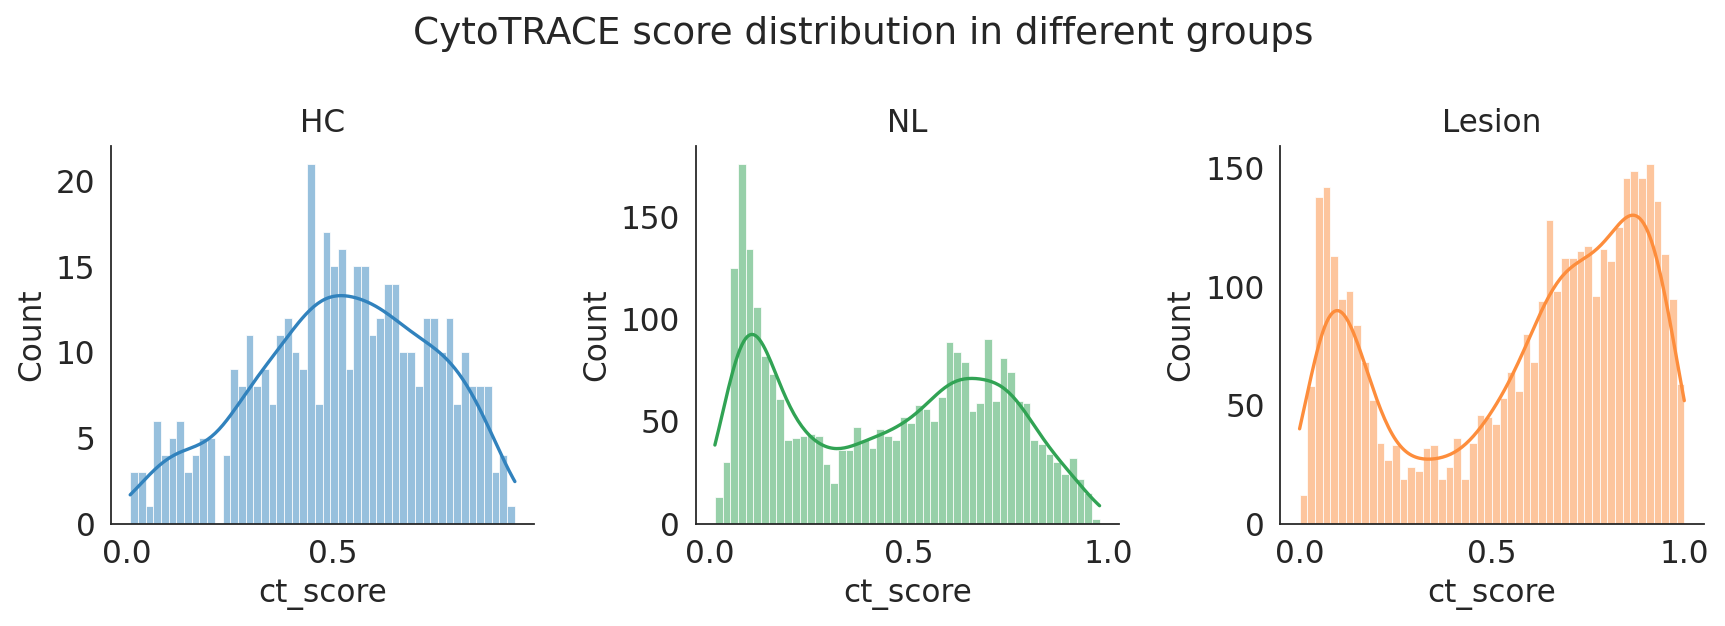

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(11, 4))
sns.histplot(adata_immu_t_cell[adata_immu_t_cell.obs.batch_group == 'HC'].obs['ct_score'], bins=50, kde=True, color=adata_immu.uns['batch_group_colors'][0], ax=axes[0])
sns.histplot(adata_immu_t_cell[adata_immu_t_cell.obs.batch_group == 'NL'].obs['ct_score'], bins=50, kde=True, color=adata_immu.uns['batch_group_colors'][1], ax=axes[1])
sns.histplot(adata_immu_t_cell[adata_immu_t_cell.obs.batch_group == 'Lesion'].obs['ct_score'], bins=50, kde=True, color=adata_immu.uns['batch_group_colors'][2], ax=axes[2])
sns.despine()
axes[0].set_title('HC')
axes[1].set_title('NL')
axes[2].set_title('Lesion')

fig.suptitle('CytoTRACE score distribution in different groups')
plt.tight_layout()
plt.savefig('figures/fig4_2/tcell_ct_score_distribution.pdf')

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


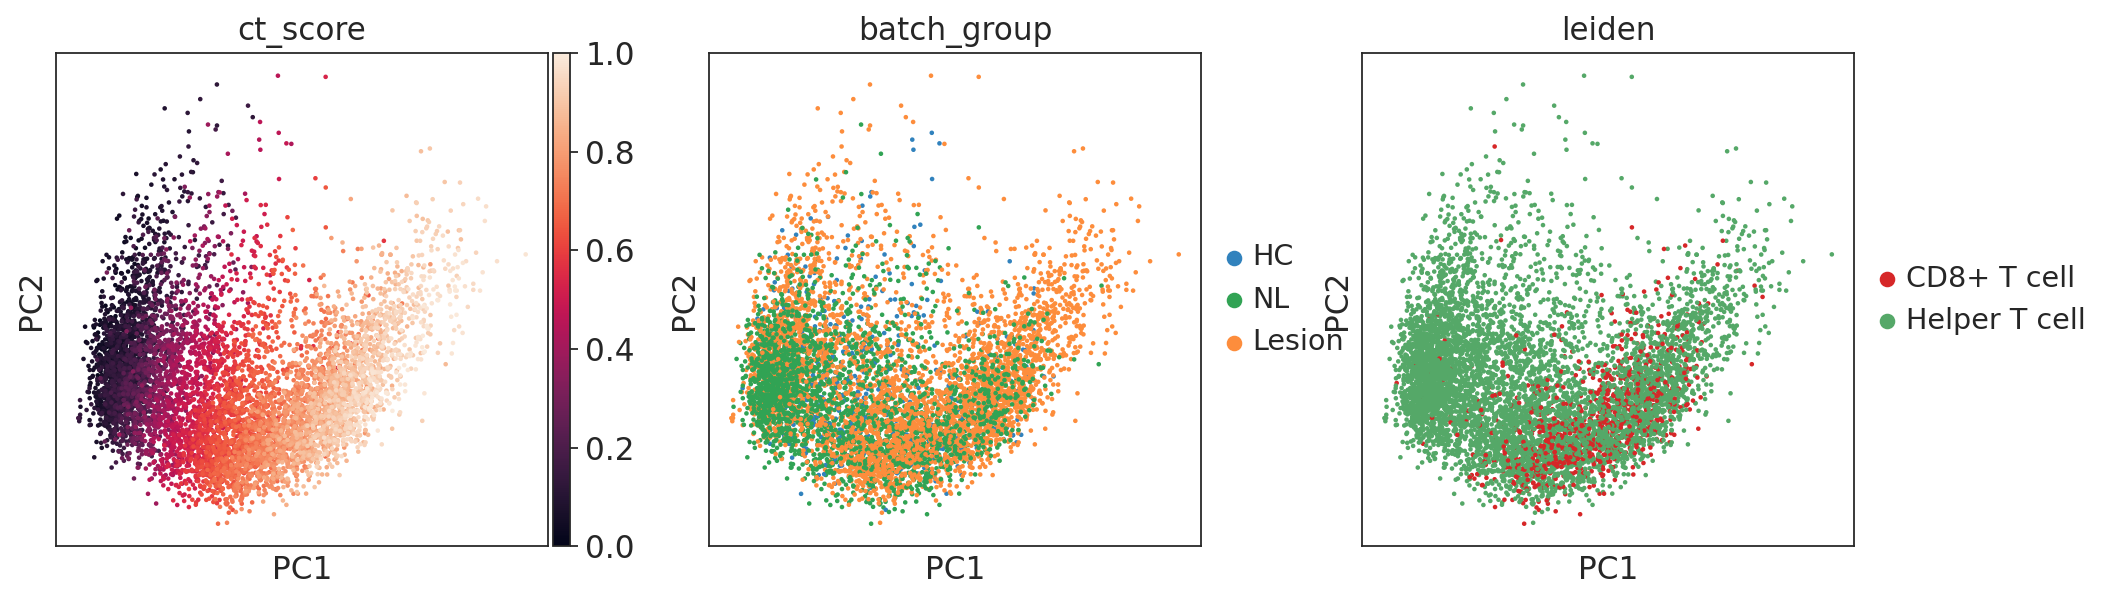

In [11]:
sc.pl.pca(adata_immu_t_cell, color=['ct_score', 'batch_group', 'leiden'])

In [13]:
scf.tl.curve(adata_immu_t_cell,Nodes=10,use_rep="X_pca",ndims_rep=2,)

inferring a principal curve --> parameters used 
    10 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.
automatic root selection using ct_score values
node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
inferring a principal curve --> parameters used 
    10 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


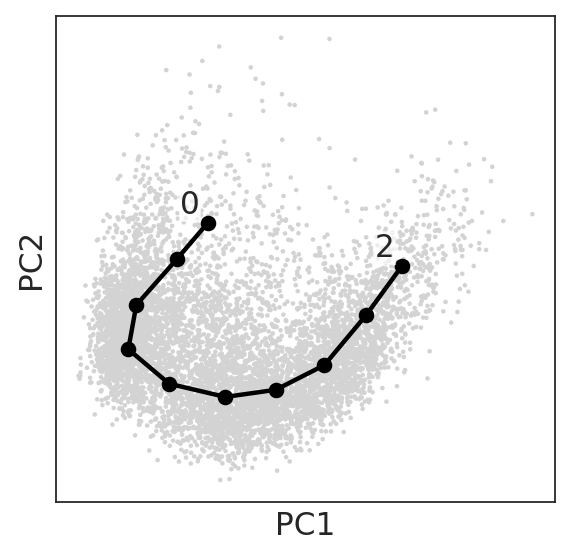

In [14]:
scf.pl.graph(adata_immu_t_cell,basis="pca")

In [15]:
scf.tl.root(adata_immu_t_cell,"ct_score")
scf.tl.pseudotime(adata_immu_t_cell,n_jobs=20,n_map=100,seed=42)

automatic root selection using ct_score values
node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]
    finished (0:00:42) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [18]:
scf.tl.test_association(adata_immu_t_cell,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|██████████| 18787/18787 [13:38<00:00, 22.96it/s]
    found 618 significant features (0:13:38) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


reapplied filters, 618 significant features


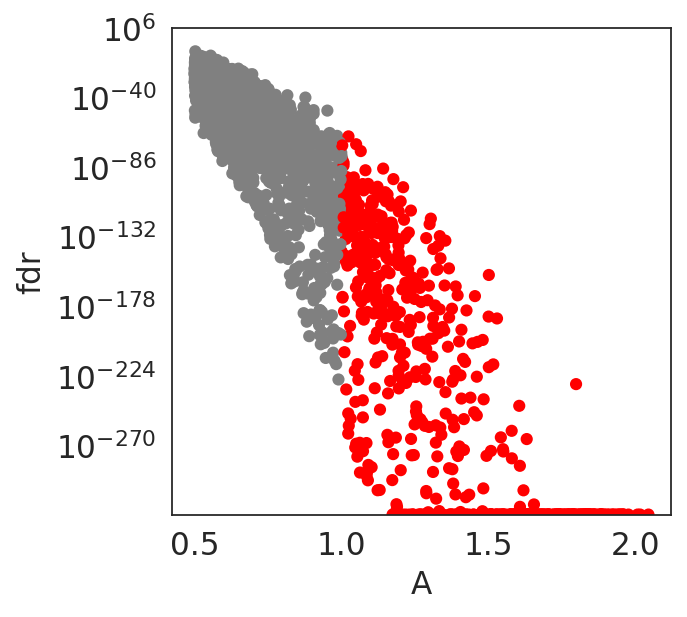

In [22]:
scf.tl.test_association(adata_immu_t_cell,reapply_filters=True,A_cut=1)
scf.pl.test_association(adata_immu_t_cell)

In [23]:
scf.tl.fit(adata_immu_t_cell,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 618/618 [02:16<00:00,  4.53it/s] 
    finished (adata subsetted to keep only fitted features!) (0:02:17) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


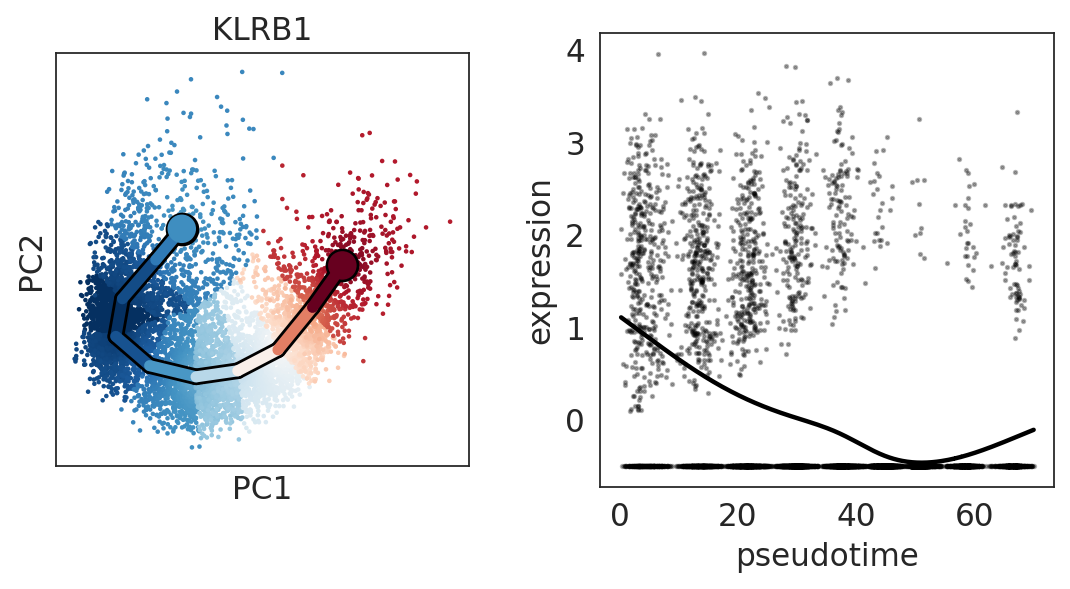

In [32]:
scf.pl.single_trend(adata_immu_t_cell,"KLRB1",basis="pca",color_exp="k")

Clustering features using fitted layer
computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
    finished (0:00:07) --> added 
    .var['clusters'] identified modules.


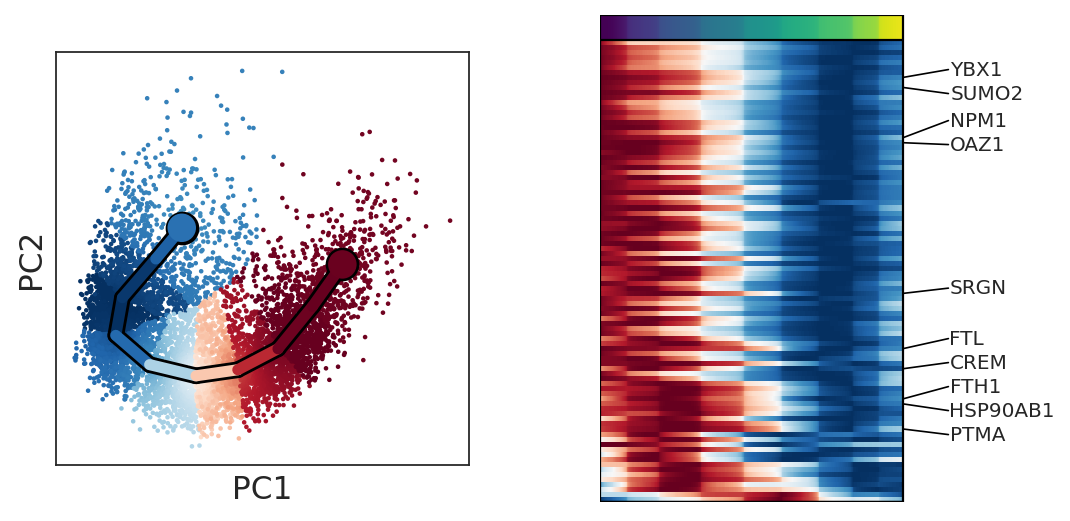

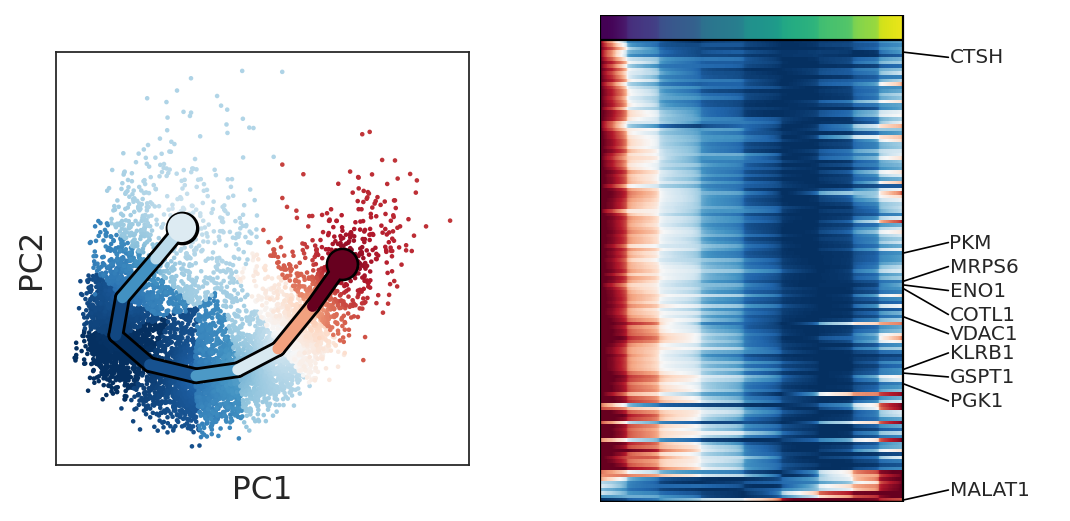

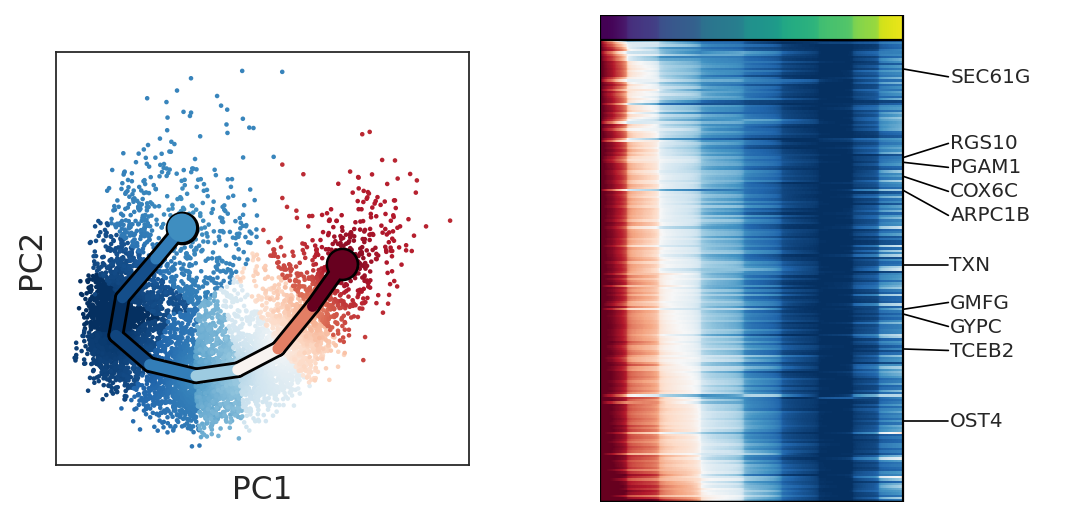

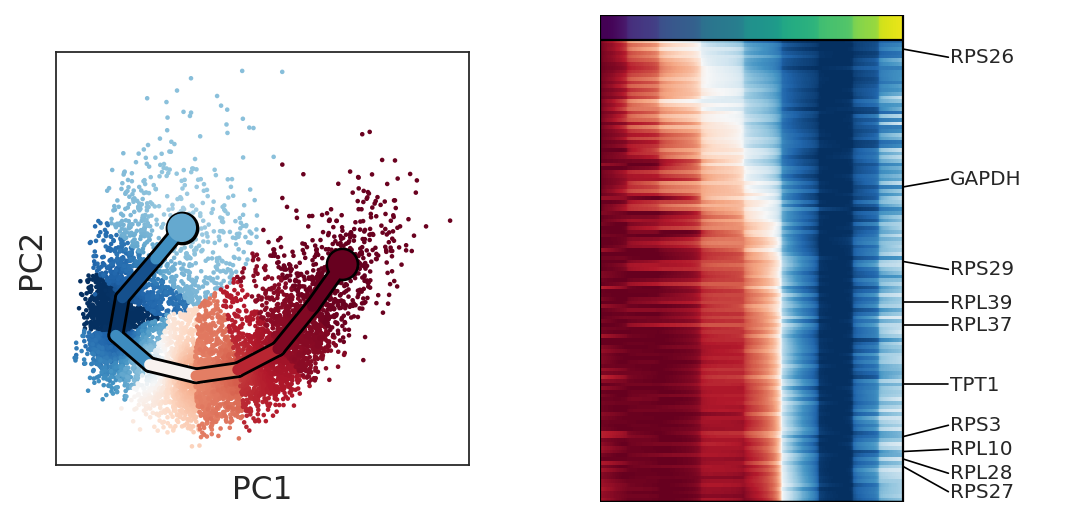

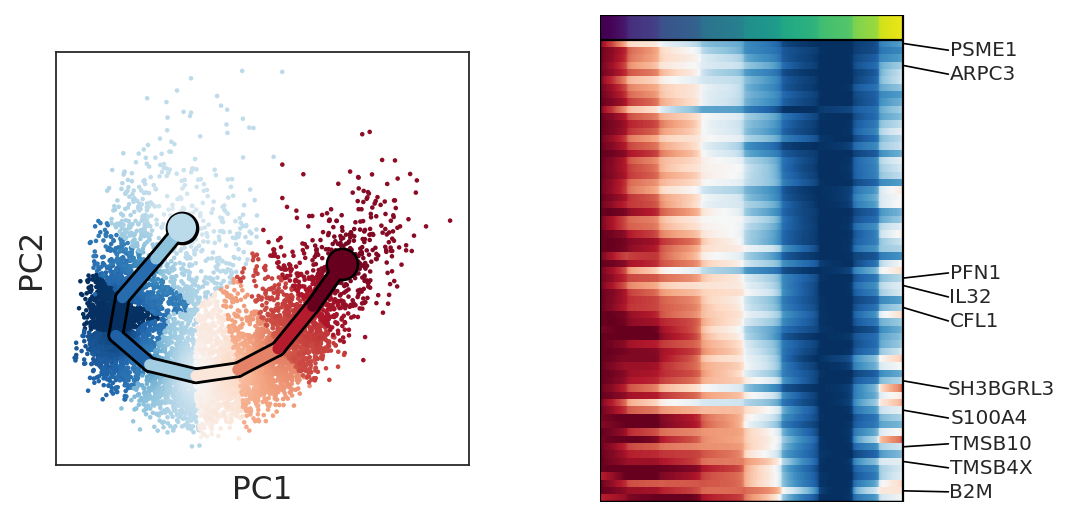

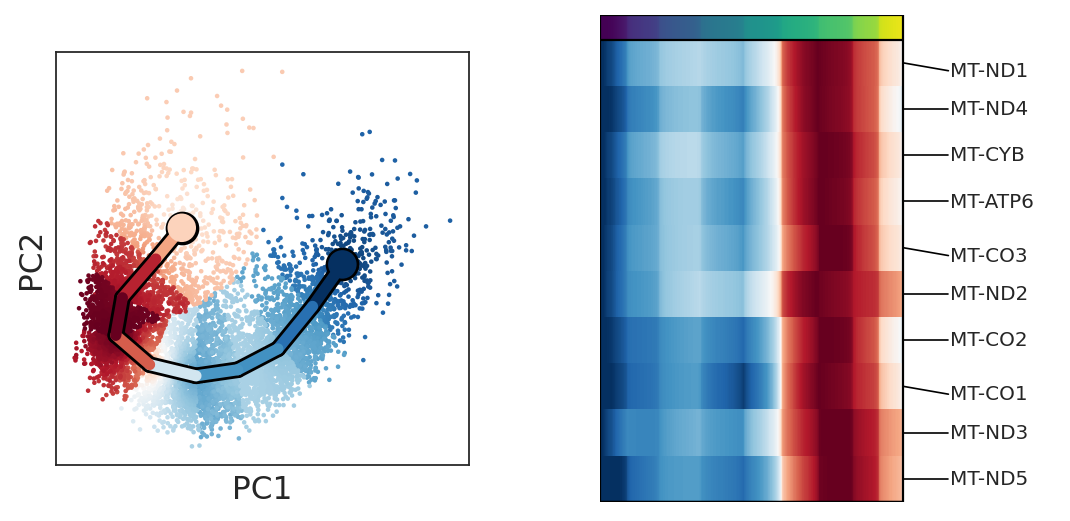

In [24]:
scf.tl.cluster(adata_immu_t_cell,n_neighbors=100,metric="correlation")
for c in adata_immu_t_cell.var["clusters"].unique():
    scf.pl.trends(adata_immu_t_cell,features=adata_immu_t_cell.var_names[adata_immu_t_cell.var.clusters==c],basis="pca")